In [1]:
from dtw import dtw
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import style
#style.use("gunplot")
from sklearn.cluster import KMeans
%matplotlib inline
from osgeo import gdal
from sklearn.externals import joblib
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import time as t
import math

In [ ]:
def graph(x, y):
    files = ["/home/faizan/Pakistan/EVI/2010/sindh.2010%03d"  % (i) + ".tif" for i in range(1, 363) ]
    ds = gdal.Open(files[0])
    evi = np.array([ds.ReadAsArray()[(x, y)]])
    for i in files[1:]:
        ds = gdal.Open(i)
        evi = np.vstack([evi, ds.ReadAsArray()[(x, y)]])
    #plt.plot(range(91, len(evi)+91), evi / 10000.)
    plt.plot(range(0, len(evi)), evi / 10000.)
    plt.show()

In [ ]:
x, y = (687, 693)
graph(x, y)

In [2]:
EVI_path= "/home/faizan/HDD1/EVI/CSV/Pak_crop_all_point_evi.csv"
data1 = pd.read_csv(EVI_path)
for p in range(49):

    data = data1[data1["ID"] == p]
    dates = [datetime.datetime.strptime(str(k), "%Y%j") for k in data["DATE"]]
    data.index = dates
    dummy = data[data.index.year > 2008]
    dummy = dummy[dummy.index.year < 2010]
    #dummy = dummy[dummy.index.month > 5]
    time = dummy.index
    evi  = dummy["EVI"]
    time1=dummy["DATE"]
"""

data = data1[data1["ID"] == 18]
dates = [datetime.datetime.strptime(str(k), "%Y%j") for k in data["DATE"]]
data.index = dates
dummy = data[data.index.year > 2008]
dummy = dummy[dummy.index.year < 2010]
dummy = dummy[dummy.index.month > 5]
time = dummy.index
evi2  = dummy["EVI"]
time2=dummy["DATE"]

data = data1[data1["ID"] == 4]
dates = [datetime.datetime.strptime(str(k), "%Y%j") for k in data["DATE"]]
data.index = dates
dummy = data[data.index.year > 2008]
dummy = dummy[dummy.index.year < 2010]
dummy = dummy[dummy.index.month > 5]
time = dummy.index
evi3  = dummy["EVI"]
time3=dummy["DATE"]
"""

'\n\ndata = data1[data1["ID"] == 18]\ndates = [datetime.datetime.strptime(str(k), "%Y%j") for k in data["DATE"]]\ndata.index = dates\ndummy = data[data.index.year > 2008]\ndummy = dummy[dummy.index.year < 2010]\ndummy = dummy[dummy.index.month > 5]\ntime = dummy.index\nevi2  = dummy["EVI"]\ntime2=dummy["DATE"]\n\ndata = data1[data1["ID"] == 4]\ndates = [datetime.datetime.strptime(str(k), "%Y%j") for k in data["DATE"]]\ndata.index = dates\ndummy = data[data.index.year > 2008]\ndummy = dummy[dummy.index.year < 2010]\ndummy = dummy[dummy.index.month > 5]\ntime = dummy.index\nevi3  = dummy["EVI"]\ntime3=dummy["DATE"]\n'

In [159]:
def euclid_dist(t1,t2):
    return np.sqrt(sum((t1-t2)**2))

In [160]:
print euclid_dist(evi,evi2)

12727.2726065


In [161]:
print euclid_dist(evi,evi3)

26396.9956245


In [162]:
print euclid_dist(evi2,evi3)

19748.9908603


NameError: name 'evi2' is not defined

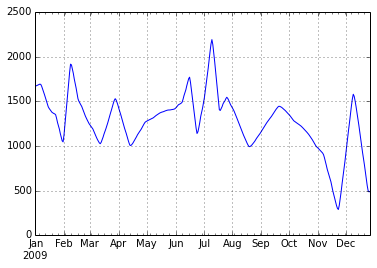

In [3]:
evi.plot()
evi2.plot()
evi3.plot()

In [11]:
def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [47]:
print DTWDistance(evi,evi2)

8457.13645391


In [48]:
print DTWDistance(evi,evi3)

25432.5154674


In [12]:
def DTWDistance(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [52]:
print DTWDistance(evi,evi2,10)

11510.2210231


In [13]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

In [57]:
print LB_Keogh(evi,evi2,30)

8731.32567254


In [14]:
from sklearn.metrics import classification_report

def knn(train,test,w):
    preds=[]
    for ind,i in enumerate(test):
        min_dist=float('inf')
        closest_seq=[]
        print ind
        print min_dist
        for j in train:
            if LB_Keogh(i[:-1],j[:-1],5)<min_dist:
                dist=DTWDistance(i[:-1],j[:-1],w)
                if dist<min_dist:
                    min_dist=dist
                    closest_seq=j
        preds.append(closest_seq[-1])
    return classification_report(test[:,-1],preds)

In [92]:
print knn(E,E,4)

0
inf
1
inf
             precision    recall  f1-score   support

     1648.0       1.00      1.00      1.00         1
     1655.0       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00         2



In [85]:
E = np.vstack((evi, evi2))
T = np.vstack((evi2, evi3))

In [94]:
E[:,-1]

array([ 1655.,  1648.])

In [6]:
EVI_path= "/home/faizan/HDD1/EVI/CSV/Pak_crop_all_point_evi.csv"
data1 = pd.read_csv(EVI_path)
for p in range(49):

    data = data1[data1["ID"] == p]
    dates = [datetime.datetime.strptime(str(k), "%Y%j") for k in data["DATE"]]
    data.index = dates
    dummy = data[data.index.year > 2008]
    dummy = dummy[dummy.index.year < 2010]
    #dummy = dummy[dummy.index.month > 5]
    time = dummy.index
    evi  = dummy["EVI"]
    time1=dummy["DATE"]
    if p==0:
        comb=evi
    else:
        comb=np.vstack((comb, evi))
    

In [7]:
len(comb[2])

361

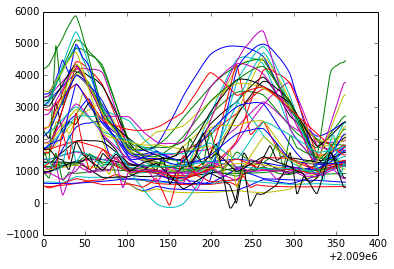

In [8]:
for i in range(49):  
    plt.plot(time1,comb[i])
plt.show()


In [20]:
import random

def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        #print counter
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:
            #print assignments
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
                
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    print counter
    return centroids

10
10
10
10
10
10


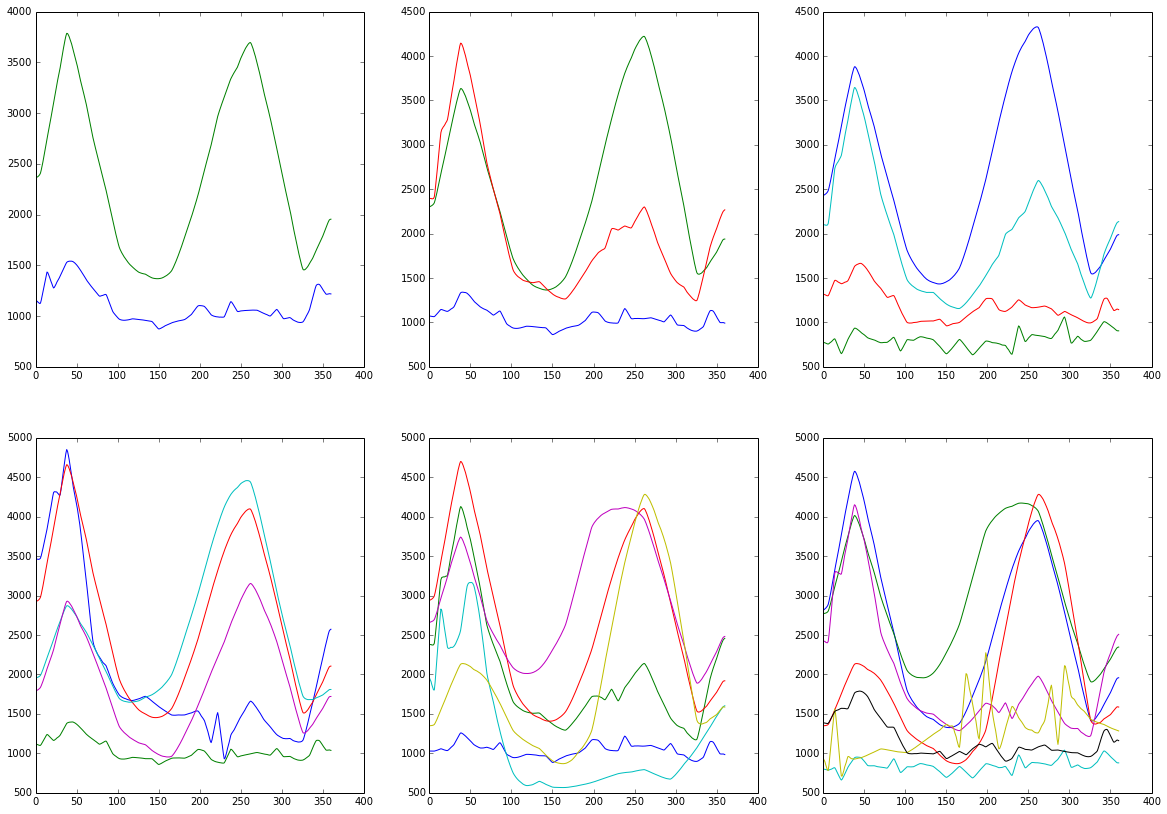

In [23]:
#train = np.genfromtxt('datasets/train.csv', delimiter='\t')
#test = np.genfromtxt('datasets/test.csv', delimiter='\t')

plt.figure(figsize=(20, 14))

for clu in xrange(2,8):
    centroids=k_means_clust(comb,clu,10,5)
    for i in centroids:
            plt.subplot(2,3,clu-1)
            plt.plot(i)
plt.savefig("/home/faizan/Desktop/clustering1.png")
plt.show()

In [22]:
plt.savefig("/home/faizan/Desktop/clustering1.png")


In [256]:
centroids=random.sample(comb,6)
for c_ind,j in enumerate(centroids):
    #print j
    print c_ind

0
1
2
3
4
5


In [30]:
ind=3
#assignments={}
closest_clust=0
if closest_clust in assignments:
    assignments[closest_clust].append(ind)
else:
    assignments[closest_clust]=[ind]

In [31]:
assignments

{0: [3], 3: [2, 2]}

In [33]:
for key in assignments:
    print key
    print assignments

0
{0: [3], 3: [2, 2]}
3
{0: [3], 3: [2, 2]}


In [62]:
data=[[1,2,8,4,5,6],[1,3,3,8,5,9],[3,2,3,4,3,6],[1,2,3,2,5,6]]
#data=[1,2,3,4,5,6]
centroids=[[1,2,3,4,5,6],[1,2,3,4,5,6],[1,2,3,4,5,6],[1,2,3,4,5,6]]
for key in assignments:
    #print assignments
    clust_sum=0
    for k in assignments[key]:
        clust_sum=np.add(clust_sum,data[k])

    centroids[key]=[clust_sum/len(assignments[key])]

In [63]:
clust_sum

array([ 6,  4,  6,  8,  6, 12])

In [64]:
centroids

[[array([1, 2, 3, 2, 5, 6])],
 [1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6],
 [array([3, 2, 3, 4, 3, 6])]]

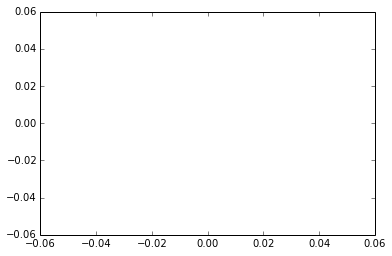

In [66]:
for i in centroids:    
    plt.plot(0)
plt.show()

In [106]:
train = np.genfromtxt('/home/faizan/Desktop/te.csv', delimiter='\t')
data=np.vstack((train[:,:-1],train[:,:-1]))
num_clust = 3
num_iter =5
w=5
centroids=random.sample(data,num_clust)
counter=0
for n in range(num_iter):
    counter+=1
    print counter
    assignments={}
    #assign data points to clusters
    for ind,i in enumerate(data):
        min_dist=float('inf')
        closest_clust=None
        for c_ind,j in enumerate(centroids):
            if LB_Keogh(i,j,5)<min_dist:
                cur_dist=DTWDistance(i,j,w)
                if cur_dist<min_dist:
                    min_dist=cur_dist
                    closest_clust=c_ind
        if closest_clust in assignments:
            assignments[closest_clust].append(ind)
        else:
            assignments[closest_clust]=[ind]

    #recalculate centroids of clusters
    for key in assignments:
        #print assignments
        clust_sum=0
        for k in assignments[key]:
            clust_sum=np.add(clust_sum,data[k])

        centroids[key]=clust_sum/len(assignments[key]) 


1
2
3
4
5


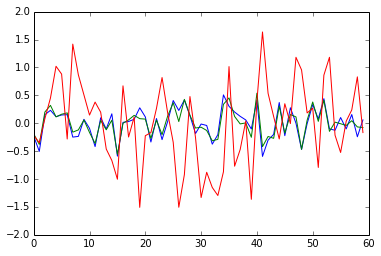

In [107]:

for i in centroids:    
    plt.plot(i)
plt.show()

In [90]:
assignments

{0: [8, 12, 17, 26, 30, 35],
 1: [4, 5, 14, 22, 23, 32],
 2: [0, 1, 7, 9, 10, 11, 13, 16, 18, 19, 25, 27, 28, 29, 31, 34],
 3: [2, 3, 6, 20, 21, 24],
 4: [15, 33]}

In [91]:
assignments[0]

[8, 12, 17, 26, 30, 35]

In [100]:
clust_sum=0
for k in assignments[0]:
    clust_sum=np.add(clust_sum,data[k])

In [101]:
clust_sum

array([ 7.41593926, -4.01752488,  1.9274526 ,  2.42634596, -5.05194796,
       -3.57344742, -3.54027464, -4.12792942, -2.51142256,  3.3886562 ,
       -0.4548747 , -0.94478182, -2.78808556, -4.23723792,  3.16299849,
        4.05511244,  0.10303942, -0.58949202, -2.60365516,  3.01954966,
        1.01417801, -3.7803416 , -3.72970542, -7.26598466,  6.10482518,
        6.65930302,  0.7267061 ,  2.8081976 ,  1.72668123,  1.3211069 ,
       -2.71602044, -2.2804153 , -3.463149  , -0.10935462,  5.32432726,
        3.26306486, -2.51791582,  3.469574  ,  0.96066485,  0.20512434,
        0.72494452, -4.35641218, -1.67751349, -2.93522582,  4.6216232 ,
        4.09001198,  0.71327482,  2.9557577 , -6.20185708, -3.65851456,
        6.66428208,  3.02101556,  1.96301664, -1.02388136,  0.06249618,
       -0.79863334, -3.80514899,  3.68006595, -1.18757234, -1.63101662])

In [102]:
A=clust_sum/len(assignments[0])
A

array([ 1.23598988, -0.66958748,  0.3212421 ,  0.40439099, -0.84199133,
       -0.59557457, -0.59004577, -0.68798824, -0.41857043,  0.56477603,
       -0.07581245, -0.15746364, -0.46468093, -0.70620632,  0.52716641,
        0.67585207,  0.01717324, -0.09824867, -0.43394253,  0.50325828,
        0.16902967, -0.63005693, -0.62161757, -1.21099744,  1.01747086,
        1.10988384,  0.12111768,  0.46803293,  0.2877802 ,  0.22018448,
       -0.45267007, -0.38006922, -0.5771915 , -0.01822577,  0.88738788,
        0.54384414, -0.41965264,  0.57826233,  0.16011081,  0.03418739,
        0.12082409, -0.7260687 , -0.27958558, -0.4892043 ,  0.77027053,
        0.68166866,  0.11887914,  0.49262628, -1.03364285, -0.60975243,
        1.11071368,  0.50350259,  0.32716944, -0.17064689,  0.01041603,
       -0.13310556, -0.6341915 ,  0.61334433, -0.19792872, -0.2718361 ])

In [96]:
centroids[0]

[1.2359898766666666,
 -0.66958748066666673,
 0.32124210000000003,
 0.40439099333333317,
 -0.84199132666666665,
 -0.59557456936666664,
 -0.5900457733333333,
 -0.68798823666666664,
 -0.41857042666666661,
 0.56477603333333326,
 -0.07581244999999999,
 -0.15746363666666671,
 -0.46468092666666672,
 -0.70620632000000005,
 0.5271664143,
 0.67585207266666669,
 0.017173236666666706,
 -0.098248670000000024,
 -0.43394252633333324,
 0.50325827666666667,
 0.16902966900000002,
 -0.63005693333333335,
 -0.62161757000000006,
 -1.2109974433333333,
 1.0174708633333334,
 1.1098838366666668,
 0.12111768333333334,
 0.46803293333333335,
 0.28778020466666671,
 0.22018448333333338,
 -0.45267007400000003,
 -0.38006921666666665,
 -0.57719149999999997,
 -0.018225769666666652,
 0.88738787666666674,
 0.54384414333333331,
 -0.41965263666666669,
 0.57826233333333332,
 0.16011080833333333,
 0.03418739000000004,
 0.12082408666666662,
 -0.72606869666666662,
 -0.27958558233333336,
 -0.48920430300000001,
 0.770270534000000

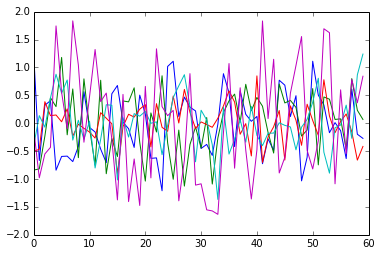

In [103]:

for i in centroids:    
    plt.plot(i)
plt.show()

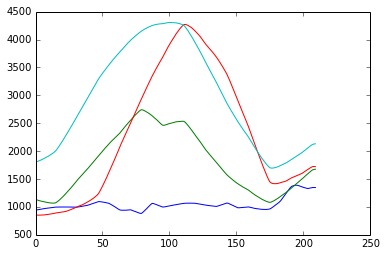

In [228]:
centroids=k_means_clust(comb,4,10,5)
for i in centroids:    
    plt.plot(i)
plt.show()

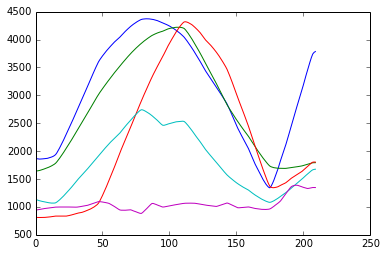

In [229]:
centroids=k_means_clust(comb,5,10,5)
for i in centroids:    
    plt.plot(i)
plt.show()

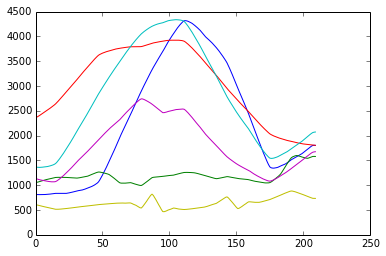

In [230]:
centroids=k_means_clust(comb,6,10,5)
for i in centroids:    
    plt.plot(i)
plt.show()

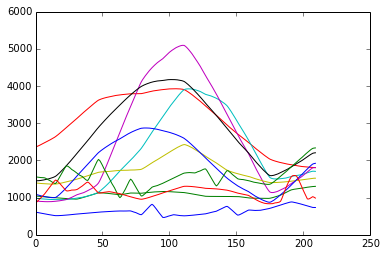

In [231]:
centroids=k_means_clust(comb,10,10,5)
for i in centroids:    
    plt.plot(i)
plt.show()

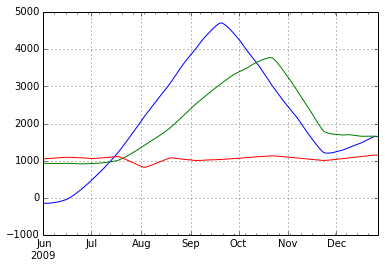

In [168]:
evi.plot()
evi2.plot()
evi3.plot()

In [188]:
centroids=k_means_clust(data,2,10,5)
for i in centroids:
    
    plt.plot(i)

plt.show()


1


TypeError: 'int' object is not iterable

In [190]:
train = np.genfromtxt('/home/faizan/Desktop/te.csv', delimiter='\t')

In [191]:
data=np.vstack((train[:,:-1],train[:,:-1]))

In [192]:
data

array([[-1.4139728 , -1.1620647 , -0.62417387, ...,  1.3630718 ,
         0.72553966, -0.88008903],
       [-1.115918  ,  0.23716141,  1.6308144 , ..., -1.3665346 ,
        -0.66266115, -1.2489139 ],
       [-1.2857446 , -0.06746462, -0.55532233, ..., -1.6829035 ,
         0.89153789,  1.5520388 ],
       ..., 
       [-0.10808234, -0.97877163, -0.55061271, ...,  0.78514926,
         0.36594352,  0.8416499 ],
       [-0.63008704, -0.5506395 ,  0.58111432, ..., -0.49145736,
        -0.96981644, -0.49904942],
       [ 0.81303753,  0.01441759,  1.2853706 , ...,  0.93264908,
         0.15278736, -0.03264544]])

1
2
3
4
5
6
7
8
9
10


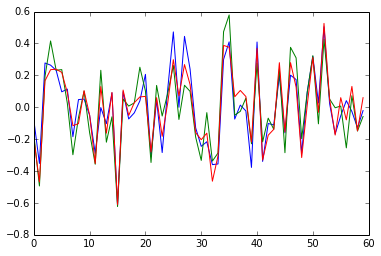

In [193]:
centroids=k_means_clust(data,3,10,5)
for i in centroids:
    
    plt.plot(i)

plt.show()

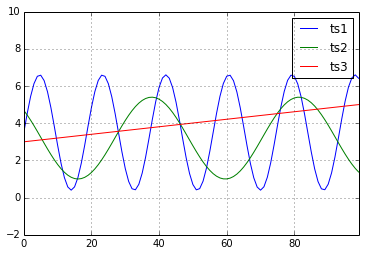

In [62]:
x=np.linspace(0,50,100)
ts1=pd.Series(3.1*np.sin(x/1.5)+3.5)
ts2=pd.Series(2.2*np.sin(x/3.5+2.4)+3.2)
ts3=pd.Series(0.04*x+3.0)

ts1.plot()
ts2.plot()
ts3.plot()

plt.ylim(-2,10)
plt.legend(['ts1','ts2','ts3'])
plt.show()

In [19]:
evi

2009-01-01    1708
2009-01-02    1719
2009-01-03    1730
2009-01-04    1742
2009-01-05    1754
2009-01-06    1767
2009-01-07    1784
2009-01-08    1808
2009-01-09    1835
2009-01-10    1864
2009-01-11    1894
2009-01-12    1924
2009-01-13    1954
2009-01-14    1986
2009-01-15    2018
2009-01-16    2048
2009-01-17    2078
2009-01-18    2108
2009-01-19    2138
2009-01-20    2169
2009-01-21    2200
2009-01-22    2231
2009-01-23    2261
2009-01-24    2291
2009-01-25    2320
2009-01-26    2348
2009-01-27    2377
2009-01-28    2404
2009-01-29    2430
2009-01-30    2456
              ... 
2009-11-28    1215
2009-11-29    1222
2009-11-30    1234
2009-12-01    1247
2009-12-02    1256
2009-12-03    1266
2009-12-04    1277
2009-12-05    1289
2009-12-06    1305
2009-12-07    1323
2009-12-08    1341
2009-12-09    1359
2009-12-10    1375
2009-12-11    1391
2009-12-12    1408
2009-12-13    1425
2009-12-14    1441
2009-12-15    1458
2009-12-16    1474
2009-12-17    1491
2009-12-18    1513
2009-12-19  

In [ ]:

D=[]
for i in range(len(evi)):
    D.append([time1[i], evi[i]])


#clf= KMeans(n_clusters=3)
clf= KMeans(n_init=20,n_clusters=3)

clf.fit(D)

centroid = clf.cluster_centers_
lables= clf.labels_

print centroid 
print lables

colors = ["g,", "r,", "c", "b", "c", "g", "d", "k"]

for l in range(len(D)):
    #print("cor:", D[l], "lab:", lables[l])
    plt.plot(D[l][0], D[l][1], colors[lables[l]], markersize=10)
    
plt.scatter(centroid[:,0], centroid[:,1], marker="x", s=150, linewidths=5, zorder=10)
plt.show()